#Object Localization&Classification Using PreTrained Faster R-CNN model with a ResNet-50 backbone and FPN (Feature Pyramid Network)

**1 - we will use VOCDetection Dataset**

**2 - use pretrained FasterRCNN with a ResNet-50 backbone**

**3 - training process for box predictor**

**Note: the Model doesn't predict with a high confidence which I visualize the predictions that there's no predictions over 80% confidince I'll work on it soon**

##1 - Downloading VOC Data&Defining Functions

In [ ]:
import torchvision
import numpy as np
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
import torch
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
def check_freeze(model):
  # A loop will go through each layer and check it's freeze state
  for name, param in model.named_parameters():
    print(f"Layer -->{name}, Trainability -->{param.requires_grad}")

In [ ]:
def train_model(model, optimizer, device, train_loader, epochs, loss_fn, val_loader = None, track_time = False):
  """
    Trains a given machine learning model on a dataset for a specified number of epochs.

    Parameters:
    ----------
    model : torch.nn.Module
        The neural network model to be trained.

    optimizer : torch.optim.Optimizer
        The optimization algorithm used to adjust the model's weights.

    device : torch.device
        The device on which the training will be executed (e.g., "cpu" or "cuda").

    train_loader : torch.utils.data.DataLoader
        DataLoader providing batches of training data and corresponding labels.

    epochs : int
        The number of complete passes through the training dataset.

    loss_fn : callable
        The loss function to measure the error between predictions and actual labels.

    val_loader : torch.utils.data.DataLoader, optional (default=None)
        DataLoader providing batches of validation data. If provided, the function
        will evaluate the model after each epoch on this dataset.

    track_time : bool, optional (default=False)
        Whether to track and display the total time taken for training. Set to True
        to enable timing, otherwise no timing information will be computed.

    Returns:
    -------
    tuple (list, list) or list:
        If `val_loader` is provided, returns a tuple containing two lists: the training
        losses and validation losses for each epoch. Otherwise, returns only a list
        of training losses.

    Notes:
    -----
    - If `track_time` is set to True, the total training time will be printed
      after training completes.
    - The loss values for both training and validation are computed as weighted
      averages across batches, normalized by dataset size.
    """
  model.to(device)
  # just two lists of losses to track losses
  train_losses = []
  val_losses = []
  total_training_time = 0

  for epoch in range(epochs):
    model.train()
    train_epoch_weighted_loss = 0
    # track the start time
    epoch_start_time = time.time() if track_time else None
    for batch_x, batch_y in train_loader:
      batch_x, batch_y = batch_x.to(device), batch_y.to(device)
      optimizer.zero_grad() # Set the gradients to zero again to make another backprop
      y_pred = model(batch_x) # The model forwarding
      loss = criterion(y_pred, batch_y)
      loss.backward()
      optimizer.step() # will update the parameters of the model

      train_epoch_weighted_loss += (len(batch_y)*loss.item())
    if track_time: # add the time taken for one epoch to the total time of train
      total_training_time += (time.time() - epoch_start_time)
    train_epoch_loss = train_epoch_weighted_loss/len(train_loader.dataset)
    train_losses.append(train_epoch_loss)
    if val_loader is not None:
      model.eval()
      correct = 0
      with torch.no_grad(): # making sure to not update the parameters of the model

        val_epoch_weighted_loss = 0
        for batch_x, batch_y in val_loader:
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)
          y_pred = model(batch_x)
          loss = criterion(y_pred, batch_y)
          val_epoch_weighted_loss += (len(batch_y)*loss.item())
          val_batch_y_pred = y_pred.argmax(dim=1) # returning the index of the maximum value in the array
          correct += (val_batch_y_pred == batch_y).sum().item() # counting the correct predictions
        val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        print(f'Epoch: {epoch + 1} / {epochs}, train_loss={train_epoch_loss}, val_loss={val_epoch_loss}. labelled {correct}/{len(val_loader.dataset)} correctly ({correct/len(val_loader.dataset)*100}% accuracy)')
    else:
      print(f'Epoch: {epoch + 1} / {epochs}, train_loss={train_epoch_loss}')
  if track_time:
    print(f'Training complete on device {device}, and {total_training_time} Seconds taken for training')
  else:
    print(f'Training complete on device {device}')
  if val_loader is not None:
    return train_losses, val_losses
  else:
    return train_losses

In [ ]:
def visualize_boxes(img, bounding_boxes, annotations):
  """
  Helper function to visualize image with all of it's bounding boxes and annotations.
  """

  fig, ax = plt.subplots(1)

  ax.imshow(img)

  for bbox, annotation in zip(bounding_boxes, annotations):

      x_min, y_min, x_max, y_max = bbox
      width = x_max - x_min
      height = y_max - y_min

      rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='b', facecolor='none')

      ax.add_patch(rect)

      plt.text(x_min, y_min - 5, annotation, color='r', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

  plt.axis('off')
  plt.show()

In [ ]:
#  Instead of using default collate function on dataloaders (which is torch.stack), we will define a custom one
#  Since the images have variable number of bounding boxes, stack won't work because stack expects all inputs to be of the same size.
def custom_collate_fn(data):
  return tuple(zip(*data))

In [ ]:
data_path = "./VOC_data/"
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])

# Load the VOC dataset
train_dataset = VOCDetection(root=data_path, year='2007', image_set='train', download=True, transform=transform)
test_dataset = VOCDetection(root=data_path, year='2007', image_set='test', download=True, transform=transform)
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# take a subset of the dataset
subset_size = 500
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
test_dataset = torch.utils.data.Subset(test_dataset, range(subset_size))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

100%|██████████| 460M/460M [00:22<00:00, 20.0MB/s]


Extracting ./VOC_data/VOCtrainval_06-Nov-2007.tar to ./VOC_data/


100%|██████████| 451M/451M [00:21<00:00, 20.8MB/s]


Extracting ./VOC_data/VOCtest_06-Nov-2007.tar to ./VOC_data/
Train dataset size: 2501
Test dataset size: 4952


##2 - Fintuning the PreTrained model and Train the box predictor

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 20 # Number of classes for VOC dataset

in_features = model.roi_heads.box_predictor.cls_score.in_features  # input features of bounding box predictor
prev_num_classes = model.roi_heads.box_predictor.cls_score.out_features

# update the bounding box prediction layers with new untrained layers which now predict 20 classes instead of previous.
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

print('Old Num Classes: ', prev_num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 112MB/s]


Old Num Classes:  91


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print('Using device', device)

Using device cuda


In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
check_freeze(model)

Layer -->backbone.body.conv1.weight, Trainability -->False
Layer -->backbone.body.layer1.0.conv1.weight, Trainability -->False
Layer -->backbone.body.layer1.0.conv2.weight, Trainability -->False
Layer -->backbone.body.layer1.0.conv3.weight, Trainability -->False
Layer -->backbone.body.layer1.0.downsample.0.weight, Trainability -->False
Layer -->backbone.body.layer1.1.conv1.weight, Trainability -->False
Layer -->backbone.body.layer1.1.conv2.weight, Trainability -->False
Layer -->backbone.body.layer1.1.conv3.weight, Trainability -->False
Layer -->backbone.body.layer1.2.conv1.weight, Trainability -->False
Layer -->backbone.body.layer1.2.conv2.weight, Trainability -->False
Layer -->backbone.body.layer1.2.conv3.weight, Trainability -->False
Layer -->backbone.body.layer2.0.conv1.weight, Trainability -->True
Layer -->backbone.body.layer2.0.conv2.weight, Trainability -->True
Layer -->backbone.body.layer2.0.conv3.weight, Trainability -->True
Layer -->backbone.body.layer2.0.downsample.0.weight, 

In [ ]:
# No need to train the backbone
# We CAN but it'll take too long and too much computation

model.requires_grad_(False)
model.roi_heads.box_predictor = model.roi_heads.box_predictor.requires_grad_(True)

In [ ]:
check_freeze(model)

Layer -->backbone.body.conv1.weight, Trainability -->False
Layer -->backbone.body.layer1.0.conv1.weight, Trainability -->False
Layer -->backbone.body.layer1.0.conv2.weight, Trainability -->False
Layer -->backbone.body.layer1.0.conv3.weight, Trainability -->False
Layer -->backbone.body.layer1.0.downsample.0.weight, Trainability -->False
Layer -->backbone.body.layer1.1.conv1.weight, Trainability -->False
Layer -->backbone.body.layer1.1.conv2.weight, Trainability -->False
Layer -->backbone.body.layer1.1.conv3.weight, Trainability -->False
Layer -->backbone.body.layer1.2.conv1.weight, Trainability -->False
Layer -->backbone.body.layer1.2.conv2.weight, Trainability -->False
Layer -->backbone.body.layer1.2.conv3.weight, Trainability -->False
Layer -->backbone.body.layer2.0.conv1.weight, Trainability -->False
Layer -->backbone.body.layer2.0.conv2.weight, Trainability -->False
Layer -->backbone.body.layer2.0.conv3.weight, Trainability -->False
Layer -->backbone.body.layer2.0.downsample.0.weigh

In [ ]:
print(type(model))

<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [ ]:
from torchsummary import summary
from collections import OrderedDict
with torch.no_grad():
  model.eval()
  modeel = torch.nn.Sequential(OrderedDict(model.backbone.body))
  summary(modeel, input_size=(3, 500, 500), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [4, 64, 250, 250]           9,408
 FrozenBatchNorm2d-2          [4, 64, 250, 250]             128
              ReLU-3          [4, 64, 250, 250]               0
         MaxPool2d-4          [4, 64, 125, 125]               0
            Conv2d-5          [4, 64, 125, 125]           4,096
 FrozenBatchNorm2d-6          [4, 64, 125, 125]             128
              ReLU-7          [4, 64, 125, 125]               0
            Conv2d-8          [4, 64, 125, 125]          36,864
 FrozenBatchNorm2d-9          [4, 64, 125, 125]             128
             ReLU-10          [4, 64, 125, 125]               0
           Conv2d-11         [4, 256, 125, 125]          16,384
FrozenBatchNorm2d-12         [4, 256, 125, 125]             512
           Conv2d-13         [4, 256, 125, 125]          16,384
FrozenBatchNorm2d-14         [4, 256, 1

In [ ]:
# Mappings of label names (found in dataset annotation) to integer IDs (or classes) which we will feed to the model

voc_classes = {
    "aeroplane": 0,
    "bicycle": 1,
    "bird": 2,
    "boat": 3,
    "bottle": 4,
    "bus": 5,
    "car": 6,
    "cat": 7,
    "chair": 8,
    "cow": 9,
    "diningtable": 10,
    "dog": 11,
    "horse": 12,
    "motorbike": 13,
    "person": 14,
    "pottedplant": 15,
    "sheep": 16,
    "sofa": 17,
    "train": 18,
    "tvmonitor": 19,
}

In [ ]:
#  Reverse of label to class id mapping. needed because the model predictions will be ids and we need to change it to label to visualize it.
reverse_voc_classes = {v: k for k, v in voc_classes.items()}

In [ ]:
reverse_voc_classes

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

##3 - Training&Evaluating the model

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = SGD(params, lr=1e-5)
optimizer = SGD(params, lr=0.00005, momentum=0.9, weight_decay=0.0005)

In [ ]:
num_epochs = 10

In [ ]:
image, target = train_loader.__iter__().__next__()
certain_image = image[0]
C, H, W = certain_image.shape
print(f"number of Channels -->{C}, Height -->{H}, Width -->{W}")
print(target)

number of Channels -->3, Height -->375, Width -->500
({'annotation': {'folder': 'VOC2007', 'filename': '001734.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '136583581'}, 'owner': {'flickrid': 'marcin747', 'name': 'Marcin Kacprzak'}, 'size': {'width': '500', 'height': '375', 'depth': '3'}, 'segmented': '0', 'object': [{'name': 'sheep', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '100', 'ymin': '84', 'xmax': '441', 'ymax': '313'}}]}}, {'annotation': {'folder': 'VOC2007', 'filename': '000256.jpg', 'source': {'database': 'The VOC2007 Database', 'annotation': 'PASCAL VOC2007', 'image': 'flickr', 'flickrid': '327451692'}, 'owner': {'flickrid': 'boeingguy', 'name': '?'}, 'size': {'width': '500', 'height': '343', 'depth': '3'}, 'segmented': '1', 'object': [{'name': 'aeroplane', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': '8', 'ymin': '96', 'xmax': '491', 'y

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:

        images = list(image.to(device) for image in images)
        for target in targets:
          boxes = []
          labels = []
          for obj in target['annotation']['object']:
            label = obj['name']
            box = obj['bndbox']
            xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
            box = torch.Tensor([xmin, ymin, xmax, ymax]).to(device)
            boxes.append(box)
            labels.append(voc_classes[label])
          target['boxes'] = torch.stack(boxes)
          target['labels'] = torch.Tensor(labels).type(torch.int64).to(device)

        # In training mode, the model will take images and targets and calculate all the losses in internal implementation
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {losses.item()}, class loss: {loss_dict['loss_classifier']}, box loss: {loss_dict['loss_box_reg']}, objectness: {loss_dict['loss_objectness']}, rpn box loss: {loss_dict['loss_rpn_box_reg']}")

Epoch 1/10, Loss: 0.8206023573875427, class loss: 0.463650107383728, box loss: 0.3185533881187439, objectness: 0.017044056206941605, rpn box loss: 0.021354783326387405
Epoch 2/10, Loss: 0.9479376077651978, class loss: 0.5232384204864502, box loss: 0.40101373195648193, objectness: 0.0011375609319657087, rpn box loss: 0.02254788763821125
Epoch 3/10, Loss: 0.637442946434021, class loss: 0.37595614790916443, box loss: 0.2506476044654846, objectness: 0.004990636371076107, rpn box loss: 0.005848598666489124
Epoch 4/10, Loss: 0.5257757902145386, class loss: 0.2885904908180237, box loss: 0.21529421210289001, objectness: 0.011952756904065609, rpn box loss: 0.009938335046172142
Epoch 5/10, Loss: 0.6295103430747986, class loss: 0.32932719588279724, box loss: 0.2764700651168823, objectness: 0.011637868359684944, rpn box loss: 0.012075159698724747
Epoch 6/10, Loss: 1.2108253240585327, class loss: 0.6581454873085022, box loss: 0.5246763229370117, objectness: 0.020543351769447327, rpn box loss: 0.007

In [ ]:
losses.item()

0.632203996181488

In [ ]:
model.eval()

clear_output()

In [ ]:
test_img, test_target = test_dataset[10]

test_boxes = []
annotations = []
for obj in test_target['annotation']['object']:
  box = obj['bndbox']
  xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
  box = [xmin, ymin, xmax, ymax]
  test_boxes.append(box)
  annotations.append(obj['name'])

with torch.no_grad():
  pred = model([test_img.to(device)])

pred = pred[0]

pred_boxes = pred['boxes']
pred_annotations = pred['labels']
pred_scores = pred['scores']

valid_mask = pred_scores>=0.8

pred_annotations = pred_annotations[valid_mask]
pred_boxes = pred_boxes[valid_mask]

pred_annotations = [reverse_voc_classes[val.item()] for val in pred_annotations]

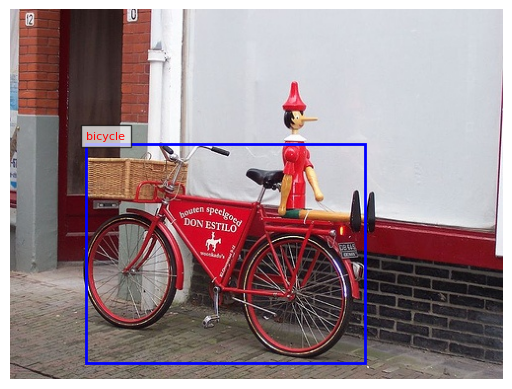

In [ ]:
#Ground truth
visualize_boxes(F.to_pil_image(test_img), test_boxes, annotations)

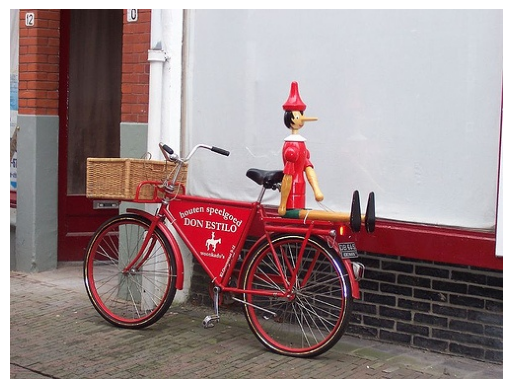

In [ ]:
# Predicted
visualize_boxes(F.to_pil_image(test_img), pred_boxes.cpu(), pred_annotations)

In [ ]:
test_img, test_target = test_dataset[20]

test_boxes = []
annotations = []
for obj in test_target['annotation']['object']:
  box = obj['bndbox']
  xmin, ymin, xmax, ymax = [int(box[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
  box = [xmin, ymin, xmax, ymax]
  test_boxes.append(box)
  annotations.append(obj['name'])

with torch.no_grad():
  pred = model([test_img.to(device)])

pred = pred[0]

pred_boxes = pred['boxes']
pred_annotations = pred['labels']
pred_scores = pred['scores']

valid_mask = pred_scores>=0.8

pred_annotations = pred_annotations[valid_mask]
pred_boxes = pred_boxes[valid_mask]

pred_annotations = [reverse_voc_classes[val.item()] for val in pred_annotations]

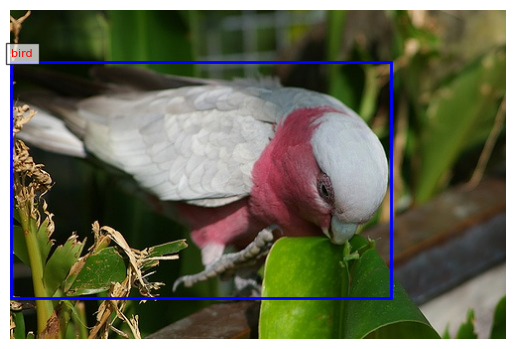

In [ ]:
visualize_boxes(F.to_pil_image(test_img), test_boxes, annotations)

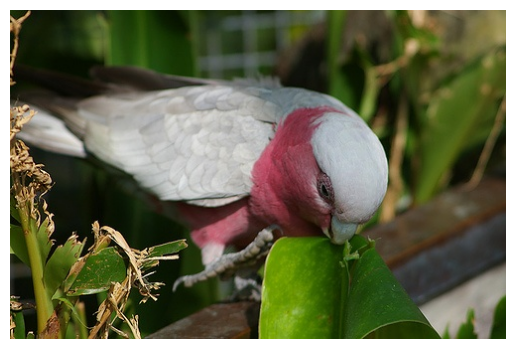

In [ ]:
visualize_boxes(F.to_pil_image(test_img), pred_boxes.cpu(), pred_annotations)